<a href="https://colab.research.google.com/github/lab-jianghao/spark_ml_sample/blob/main/04_handwrite_digit_MLP_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-17-jdk-headless

!wget https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz /content
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
!pip install pyspark==3.5.0

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .getOrCreate()

In [6]:
from functools import wraps

def spark_sql_initializer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        spark = SparkSession.builder\
            .appName("Colab_DT")\
            .master("local[*]")\
            .getOrCreate()

        spark.sparkContext.setLogLevel("WARN")

        func(spark,*args, **kwargs)

        spark.stop()

    return wrapper

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


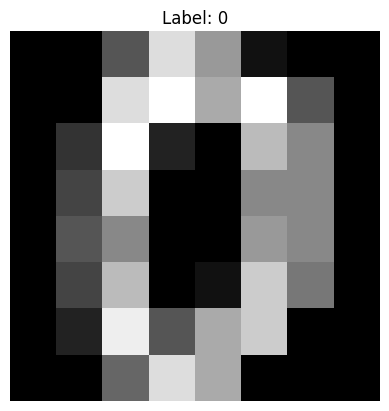

In [53]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()

images = digits.images
labels = digits.target


for i in range(1):
    data = images[i].reshape(8, 8)
    print(data)

    plt.subplot(1, 1, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.show()


In [80]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


@spark_sql_initializer
def train(spark, df):
    digits_df = spark.createDataFrame(df)

    feature_columns = digits_df.columns[:-1]

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    layers=[len(feature_columns), 36, 18, 10]

    mlp_classifier = MultilayerPerceptronClassifier(
        labelCol="label", featuresCol="features", predictionCol="prediction", maxIter=100, layers=layers, seed=2023)


    svm_pipeline = Pipeline(stages=[vector_assembler, mlp_classifier])

    training_data, test_data = digits_df.randomSplit([0.7, 0.3])
    svm_model = svm_pipeline.fit(training_data)
    svm_prediction = svm_model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(svm_prediction)

    print("Test Accuracy = {:.2%}".format(accuracy))

    svm_prediction.select("label", "prediction").show()



In [81]:
import pandas as pd

digits_df = pd.DataFrame(digits.data, columns=[f"feature_{i}" for i in range(digits.data.shape[1])])
digits_df["label"] = digits.target

train(digits_df)

Test Accuracy = 94.78%
+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    9|       9.0|
|    1|       1.0|
|    4|       4.0|
|    1|       1.0|
|    1|       1.0|
|    2|       2.0|
|    4|       4.0|
|    1|       1.0|
|    9|       9.0|
|    9|       9.0|
|    9|       9.0|
|    4|       4.0|
|    4|       4.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    9|       9.0|
|    4|       4.0|
|    2|       2.0|
+-----+----------+
only showing top 20 rows

